In [33]:
import numpy as np
import pandas as pd
import time
import pickle
import os
import re

from tqdm import tqdm
from scapy.all import rdpcap
from pipelinetools import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

In [34]:
def load_and_merge_traces(folder):
    merged_traces = {}

    for filename in sorted(os.listdir(folder)):
        match = re.match(r'website_(\d+)_processed\.npz$', filename)
        if not match:
            continue

        website_id = int(match.group(1))
        file_path = os.path.join(folder, filename)

        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            if website_id in merged_traces:
                raise ValueError(f"Duplicate website_id {website_id} found.")
            merged_traces[website_id] = data[website_id]

    return merged_traces

In [35]:
data_dir = "/Users/michaelwrana/Documents/fia-analysis/pcap_analysis/new_dataset/"
traces = load_and_merge_traces(data_dir)

In [36]:
traces_kfp = process_traces(traces, 'kfp')

100%|███████████████████████████████████████████████████████| 49/49 [20:52<00:00, 25.55s/it]


In [37]:
X, y = traces_to_xy(traces_kfp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_jobs=2, n_estimators=100, oob_score = True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)

print("k-Fingerprinting Test Accuracy: " + str(score))

k-Fingerprinting Test Accuracy: 0.9887640449438202


In [19]:
with open("importances", 'wb') as f:
    pickle.dump(model.feature_importances_, f)

In [20]:
from kfp_extraction import extract_features
tuple_format = [(abs(packet),np.sign(packet)) for packet in traces[0][0]]
tags = extract_features(tuple_format, return_tags=True)
tags_list = tags.split(',')

In [21]:
feature_names = tags_list + ["no label"] * 125
with open("importances", 'rb') as f:
    importances = pickle.load(f)

Text(0, 0.5, 'Mean decrease in impurity')

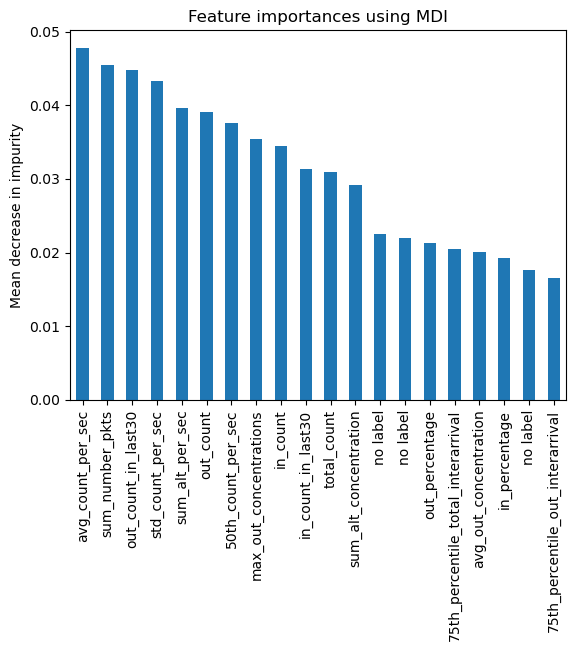

In [22]:
forest_importances = pd.Series(reversed(np.sort(importances)[-20:]), index=reversed([feature_names[i] for i in np.argsort(importances)[-20:]]))
                                                                 
fig, ax = plt.subplots()                                                              
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [ ]:
# avg_order_out: average number of outgoing packets between each incoming packet
# 75th_percentile_out_interarrival: 75th percentile of outgoing packets' interarrival times
# sum_number_pkts: 2 * total number of packets
# std_count_per_sec: standard deviation of the number of packets per second
# in_count: number of incoming packets

# no label: related to packet concentration and ordering features